This Notebook demostrate the functionality of discrete seasonality. 
Discrete seanality core algorithm expects a data of 12 rows and each row will represent each month. 
Also the rows are ordered by month. Ex. : January at row 0 and December at row 11. 

The core algorithm is stateless. Given each month's representation at each rows it tries to figure out which month are most similar by given representation and group 2 at a time and continue until breaking condtion is reached. 

Here more crticial part is how do you want to represent the data to represent a month?
Do you want to use Booking trend data?
Booking Trend by what?
Do you want to include night qty and room qty in data?
Do you want to include each individual dates?

Or do you want to represnt each month by sales statistics?
This actually make more sense from SHS perspective...but queston is can we gather that data?
It is just 12 row, aggregated at highest level. 

Irespective whatever we decide everything I can think of, have been handled. 

As the name suggests, it doesn't care about the "adjacency" of 2 months befre combining them. 


In [1]:
import pandas as pd
from math import sqrt as sqrtz
import numpy as np
import re
import copy
import logging
from numpy.linalg import norm
import scipy.cluster.hierarchy as shc
from sklearn import decomposition
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
logging.basicConfig(format="%(asctime)s - %(thread)s - %(levelname)s - %(message)s")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
def ClusterMonths_Discrete(data, plot=True):
    
    tree = shc.linkage(data, method='ward')
    if plot:
        dend = shc.dendrogram(tree)
        
    vertices = {i:tuple([i]) for i in range(12)}
    i=0
    while len(vertices)>2:
        m = max(vertices.keys())
        vx1 = tree[i, 0]
        vx2 = tree[i, 1]
        distance = tree[i, 2]
        if len(vertices)==3 and distance>=1: 
            break
        newVxKey = m + 1
        vx1Val = vertices.get(int(vx1))
        vx2Val = vertices.get(int(vx2))
        newVxVal = vx1Val + vx2Val
        del vertices[vx1]
        del vertices[vx2]
        vertices[newVxKey] = newVxVal
        i+=1
    
    l = {}
    for key in vertices.keys():
        l[key] = len(vertices[key])
    
    if min(l.items(), key=lambda x: x[1])[1] == 1:
        vertices = mergeWithNextMinimum(vertices, l)
        
    clusters = {}
    ii=0
    for key in vertices.keys():
        ii+=1
        months = [i+1 for i in vertices[key]]
        cKey = '{}-{}'.format('Cluster', ii)
        clusters[cKey] = months
        
    return clusters

def mergeWithNextMinimum(vertices, l):
    l = sorted(l.items(), key=lambda x: x[1])
    vx1 = l[0][0]
    vx2 = l[1][0]
    m = max(vertices.keys())
    newVxKey = m + 1
    vx1Val = vertices.get(int(vx1))
    vx2Val = vertices.get(int(vx2))
    newVxVal = vx1Val + vx2Val
    del vertices[vx1]
    del vertices[vx2]
    vertices[newVxKey] = newVxVal
    return vertices

In [4]:
def readPurchaseData(sourcePath, delim=';'):
#    *** This is a Placeholder Function to demostrate the future scope and purpose ***
#    *** As it is a place holder function the data preparation and validations are not extensive ***
#    At this stage the demo data(structured in .csv format) it reads, has each column as a attribute/product
#    and each row potrays the the products/attributes shopped/purchased by each month for an entity(store). 
#    each index depicts numerical value of each month.
    try:
        df = pd.read_csv(sourcePath, delimiter=delim)
    except IOError:
        print ("Could not read the file at {}".format(sourcePath))
        return None
    newColumnNames = {}
    for col in df.columns:
        if col == 'Unnamed: 0' or col == 'unnamed: 0':
            df.drop(columns=col, inplace = True)
        else:
            newColumnNames[col] = col.strip()
            
    df.rename(columns=newColumnNames, inplace=True)
    df.fillna(value=0.0)
    for col in df.columns:
        df[col] = ((df[col]-df[col].min())/(df[col].max()-df[col].min()))
    df.reset_index(inplace=True, drop = True)
    df.index = df.index + 1
    return df


In [7]:
purchaseDataFilePath = 'ProductBoughtByMonthData.csv'
purchaseData = readPurchaseData(purchaseDataFilePath, delim=',')

{'Cluster-1': [1, 10, 2, 12],
 'Cluster-2': [9, 7, 8],
 'Cluster-3': [11, 6, 4, 3, 5]}

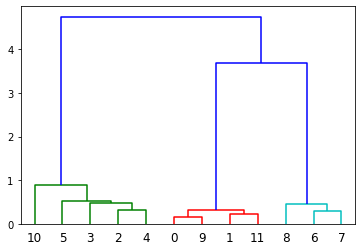

In [8]:
clusters = ClusterMonths_Discrete(data=purchaseData, plot=True)

clusters

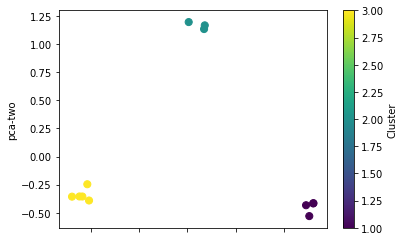

In [9]:
df_subset = pd.DataFrame()

colorsByClusters = {'Cluster-1':'r', 'Cluster-2': 'b', 'Cluster-3':'g','Cluster-4':'c'}
clustersInverse = {v: k for k, vl in clusters.items() for v in vl}
pca = decomposition.PCA(n_components=2)
pca_result = pca.fit_transform(purchaseData.values)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]
df_subset['Month'] = df_subset.index + 1
df_subset['Cluster'] = df_subset['Month'].apply(lambda x: int(clustersInverse.get(x)[-1]))
df_subset.plot.scatter(x="pca-one", y ="pca-two", c='Cluster', colormap='viridis', s = 50)

In [10]:
tree = shc.linkage(purchaseData, method='ward')

In [11]:
tree

array([[ 0.        ,  9.        ,  0.14502996,  2.        ],
       [ 1.        , 11.        ,  0.21903407,  2.        ],
       [ 6.        ,  7.        ,  0.30203873,  2.        ],
       [ 2.        ,  4.        ,  0.31139839,  2.        ],
       [12.        , 13.        ,  0.3169381 ,  4.        ],
       [ 8.        , 14.        ,  0.44456658,  3.        ],
       [ 3.        , 15.        ,  0.47958603,  3.        ],
       [ 5.        , 18.        ,  0.53236382,  4.        ],
       [10.        , 19.        ,  0.88633674,  5.        ],
       [16.        , 17.        ,  3.67966084,  7.        ],
       [20.        , 21.        ,  4.74996612, 12.        ]])